In [3]:
import sys
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import albumentations as albu

from pathlib import Path
from collections import defaultdict
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
from albumentations.pytorch.transforms import ToTensor
from sklearn.model_selection import StratifiedKFold
# from Losses import ComboLoss, dice_metric

In [4]:
try:
    get_ipython().__class_._name__
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm

In [5]:
image_count    = 612
DATA_DIR       = Path(f'data/')
TRAIN_IMG_DIR  = DATA_DIR/'images'
TRAIN_MASK_DIR = DATA_DIR/'masks'
RLE_DF_PATH    = 'rle.csv'
KFOLD_PATH     = 'rle_kfold.csv'
FOLD_ID        = 4

In [6]:
def map_binary(mask):
    (threshold, black_and_white) = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return black_and_white

In [7]:
def rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')

    last_elem = 0
    running_length = 0

    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)

    return rle

In [49]:
def visualize(**images):
    """PLot images in one row."""
    images = {k:v.numpy() for k,v in images.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy 
    n = len(images)
    plt.figure(figsize=(16, 8))
    image, mask = images['image'], images['mask']
    plt.imshow(image.transpose(1,2,0), vmin=0, vmax=1)
    if mask.max()>0:
        plt.imshow(mask.squeeze(0), alpha=0.25)
    plt.show()

In [59]:
data = {}
image_ids = []
encoded_pixels = []
for file in tqdm(list(TRAIN_MASK_DIR.glob('**/*.tif'))):
    img = cv2.imread(str(file), 0)
    black_and_white = map_binary(img)
    rle_encoded = rle(black_and_white)
    image_ids.append(file.stem)
    encoded_pixels.append(str(rle_encoded['counts'])[1:-1])

data['ImageId'] = image_ids
data['EncodedPixels'] = encoded_pixels
rle_df = pd.DataFrame(data, columns=['ImageId', 'EncodedPixels'])
rle_df.to_csv(RLE_DF_PATH, index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 612/612 [00:34<00:00, 17.88it/s]


In [8]:
RLE_DF = pd.read_csv(RLE_DF_PATH, names=['ImageId', 'EncodedPixels'], skiprows=1)
print(RLE_DF.head())

kf = StratifiedKFold()

RLE_DF['has_mask'] = 0
RLE_DF.loc[RLE_DF.EncodedPixels != '-1', 'has_mask'] = 1
RLE_DF['kfold'] = -1
for fold, (train_index, test_index) in enumerate(kf.split(X=RLE_DF.ImageId, y=RLE_DF.has_mask)):
    RLE_DF.loc[test_index, 'kfold'] = fold
    
RLE_DF.to_csv(KFOLD_PATH, index=False)

   ImageId                                      EncodedPixels
0        1  11677, 54, 1, 8, 1, 14, 210, 53, 2, 8, 2, 1, 1...
1       10  11575, 9, 10, 10, 258, 35, 252, 75, 212, 142, ...
2      100  19728, 9, 274, 19, 263, 28, 256, 35, 251, 38, ...
3      101  47679, 11, 274, 18, 268, 26, 260, 31, 255, 38,...
4      102  47951, 24, 262, 27, 259, 32, 255, 35, 252, 37,...


In [9]:
DF = pd.read_csv(KFOLD_PATH)
TRAIN_DF = DF.query(f'kfold!={FOLD_ID}').reset_index(drop=True)
VAL_DF = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)

In [53]:
class Dataset():
    def __init__(self, rle_df, image_base_dir, masks_base_dir, augmentation=None):
        self.df             = rle_df
        self.image_base_dir = image_base_dir
        self.masks_base_dir = masks_base_dir
        self.image_ids      = rle_df.ImageId.values
        self.augmentation   = augmentation
    
    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(str(self.image_base_dir), str(image_id)+'.tif') 
        mask_path = os.path.join(str(self.masks_base_dir), str(image_id)+'.tif')
        image     = cv2.imread(img_path, 1)
        mask      = cv2.imread(mask_path, 0)     
        
        # apply augmentations
        if self.augmentation:
            sample = {"image": image, "mask": mask}
            sample = self.augmentation(**sample)
            image, mask = sample['image'], sample['mask']

        return {
            'image': image, 
            'mask' : mask
        }
        
    def __len__(self):
        return len(self.image_ids)

In [54]:
train_transformations = albu.Compose([
    albu.HorizontalFlip(),
    albu.Rotate(10),
    albu.Normalize(),
    ToTensor()
])

test_transformations = albu.Compose([
    albu.Normalize(),
    ToTensor()
])

In [55]:
train_dataset = Dataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_MASK_DIR, train_transformations)
test_dataset = Dataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_MASK_DIR, test_transformations)

In [56]:
image, mask = train_dataset[2]['image'], train_dataset[2]['mask']
image.shape, mask.shape

(torch.Size([3, 288, 384]), torch.Size([1, 288, 384]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


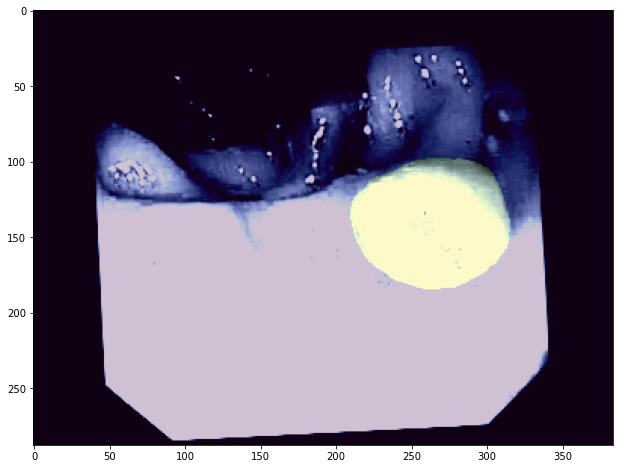

In [57]:
visualize(**train_dataset[2])